In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import seaborn as sns
import os
import admix
from os.path import join
import itertools
import admix_genet_cor
import submitit
import glob
from scipy.stats import pearsonr, linregress
from tqdm import tqdm
import string

In [3]:
df_params = pd.DataFrame(
    [
        params
        for params in itertools.product(
            #             np.arange(0, 100), [0.002, 0.004, 0.006], [1, 3, 6, 11, 21, 41]
            np.arange(0, 30),
            [0.006],
            [1, 41],
        )
    ],
    columns=["region", "hsq", "ncausal"],
)
df_params["prefix"] = df_params.apply(
    lambda row: f"region-{int(row.region)}-hsq-{row.hsq}-ncausal-{int(row.ncausal)}",
    axis=1,
)

In [4]:
dict_df_res = {}

for group in ["causal", "clump"]:
    df_res = []
    for param_i, param in tqdm(df_params.iterrows(), total=len(df_params)):
        for sim_i in range(30):
            path = f"out/summary/{param.prefix}/sim_{sim_i}.{group}.tsv"
            if os.path.exists(path):
                df_tmp = pd.read_csv(path, sep="\t")
                df_tmp["region"] = param.region
                df_tmp["ncausal"] = param.ncausal
                df_tmp["hsq"] = param.hsq
                df_tmp["sim_i"] = sim_i
                df_tmp["pos"] = df_tmp.snp.apply(lambda x: int(x.split(":")[1]))
                df_res.append(df_tmp)

    df_res = pd.concat(df_res).reset_index(drop=True)
    # filter for SNPs with super small MAF in either one of the populations
    df_res = df_res[(df_res.se1 > 1e-6) & (df_res.se2 > 1e-6)]
    print(group, np.mean(df_res.het_pval < 0.05))
    dict_df_res[group] = df_res

100%|██████████| 60/60 [00:39<00:00,  1.51it/s]


causal 0.5432804232804233


100%|██████████| 60/60 [00:45<00:00,  1.33it/s]


clump 0.5788698494809067


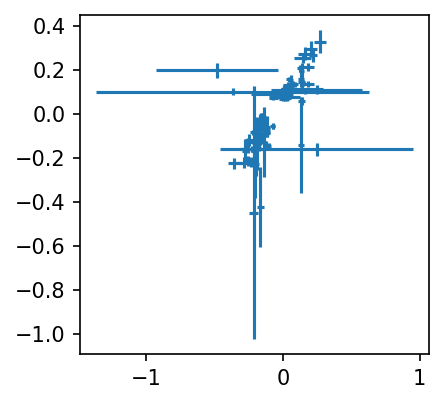

In [27]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
df_tmp = df_tmp[(df_tmp.se1 > 1e-6) & (df_tmp.se2 > 1e-6)]
ax.errorbar(
    x=df_tmp.coef1, y=df_tmp.coef2, xerr=df_tmp.se1, yerr=df_tmp.se2, fmt="none"
)
admix_genet_cor.locus.deming_regression(
    x=df_tmp.coef1, y=df_tmp.coef2, sx=df_tmp.se1, sy=df_tmp.se2
)
df_tmp[["coef1", "coef2", "se1", "se2"]].to_csv("tmp.csv", index=False)

In [19]:
df_tmp.sort_values("se1")

,snp,het_pval,coef1,se1,coef2,se2,assoc_p,region,ncausal,hsq,sim_i,pos
16,chr1:58787944:G:A,2.148264e-03,-0.147453,0.014553,-0.050037,0.029703,4.296791e-22,29,41,0.006,29,58787944
11,chr1:58211325:G:A,5.406444e-13,-0.140608,0.015504,-0.016382,0.012527,2.339166e-08,29,41,0.006,29,58211325
4,chr1:57631580:G:T,3.496406e-17,-0.159342,0.015783,-0.024247,0.011878,7.659427e-09,29,41,0.006,29,57631580
3,chr1:57555092:C:T,4.966801e-14,-0.150659,0.016002,-0.020220,0.012075,1.256334e-08,29,41,0.006,29,57555092
78,chr1:74431132:C:T,4.593542e-04,0.059211,0.016228,0.152152,0.022405,4.797074e-11,29,41,0.006,29,74431132
...,...,...,...,...,...,...,...,...,...,...,...,...
19,chr1:59002839:A:G,2.613267e-01,-0.081387,0.152236,0.089991,0.014319,5.050479e-10,29,41,0.006,29,59002839
27,chr1:60239567:C:A,6.824419e-01,0.245962,0.332307,0.109830,0.019597,1.800885e-08,29,41,0.006,29,60239567
59,chr1:67601854:G:A,1.281452e-01,-0.482749,0.445743,0.197358,0.034783,2.501911e-08,29,41,0.006,29,67601854
89,chr1:76356732:C:G,5.607374e-01,0.248038,0.704655,-0.162199,0.028775,1.953578e-08,29,41,0.006,29,76356732


In [6]:
df_res

,snp,het_pval,coef1,se1,coef2,se2,assoc_p,region,ncausal,hsq,sim_i,pos
0,chr1:10979510:T:C,0.062048,-0.032670,0.025990,-0.078916,0.013543,2.434002e-08,0,1,0.006,0,10979510
1,chr1:11538011:C:T,0.122975,-0.189295,0.045347,-0.118729,0.011103,2.099165e-28,0,1,0.006,0,11538011
2,chr1:11538011:C:T,0.016953,-0.225846,0.045161,-0.117051,0.011057,1.598360e-28,0,1,0.006,1,11538011
3,chr1:11542052:G:T,0.611525,-0.237812,0.051344,-0.199565,0.055336,5.495517e-09,0,1,0.006,1,11542052
4,chr1:11538011:C:T,0.249451,0.153798,0.045387,0.101063,0.011113,6.569659e-21,0,1,0.006,2,11538011
...,...,...,...,...,...,...,...,...,...,...,...,...
168941,chr1:76007614:G:C,0.008775,0.138257,0.024462,0.059310,0.019101,1.069266e-08,29,41,0.006,29,76007614
168942,chr1:76325325:T:A,0.268122,0.219431,0.031771,0.269013,0.032564,6.308318e-26,29,41,0.006,29,76325325
168943,chr1:76356732:C:G,0.560737,0.248038,0.704655,-0.162199,0.028775,1.953578e-08,29,41,0.006,29,76356732
168944,chr1:76719241:T:A,0.666834,0.100161,0.016788,0.107172,0.011927,9.881276e-21,29,41,0.006,29,76719241


In [5]:
def summarize_res(df_res_grouped):
    # 1st local ancestry = AFR, 2nd local ancestry = EUR
    df_plot = pd.DataFrame(
        {
            "het_inflation": df_res_grouped.apply(
                lambda x: admix.data.lambda_gc(x["het_pval"])
            ),  # HET p-value
            "het_fpr": df_res_grouped.apply(lambda x: np.mean(x["het_pval"] < 0.05)),
            "pearsonr": df_res_grouped.apply(
                lambda x: pearsonr(x["coef1"], x["coef2"])[0]
            ),  # Pearson's correlation between two coefficents
            "deming_eur~afr": df_res_grouped.apply(
                lambda x: admix_genet_cor.locus.deming_regression(
                    x=x["coef1"], y=x["coef2"], sx=x["se1"], sy=x["se2"]
                )[0]
            ),  # EUR ~ AFR
            "deming_afr~eur": df_res_grouped.apply(
                lambda x: admix_genet_cor.locus.deming_regression(
                    x=x["coef2"], y=x["coef1"], sx=x["se2"], sy=x["se1"]
                )[0]
            ),  # AFR ~ EUR
            "ols_eur~afr": df_res_grouped.apply(
                lambda x: linregress(x=x["coef1"], y=x["coef2"])[0]
            ),
            "ols_afr~eur": df_res_grouped.apply(
                lambda x: linregress(x=x["coef2"], y=x["coef1"])[0]
            ),
        }
    )

    df_plot = df_plot.reset_index(drop=False)
    return df_plot

In [5]:
dict_df_plot = {}

for group in ["causal", "clump"]:
    df_plot = summarize_res(
        dict_df_res[group].groupby(["ncausal", "hsq", "sim_i"])
    ).drop(columns=["sim_i"])
    df_plot_mean = df_plot.groupby(["ncausal", "hsq"]).mean().reset_index()
    df_plot_sem = df_plot.groupby(["ncausal", "hsq"]).sem().reset_index()

    dict_df_plot[group] = (df_plot_mean, df_plot_sem)

In [6]:
for group in ["causal", "clump"]:
    print(group + ":")
    df_plot_mean, df_plot_sem = dict_df_plot[group]
    display(
        df_plot_mean.set_index(["ncausal", "hsq"]).round(3).astype(str)
        + "±"
        + df_plot_sem.set_index(["ncausal", "hsq"]).round(3).astype(str)
    )

causal:


het_inflation      het_fpr     pearsonr deming_eur~afr  \
ncausal hsq                                                            
1       0.002   0.995±0.042  0.052±0.006  0.911±0.005      1.0±0.009   
        0.004   0.977±0.041  0.054±0.004   0.94±0.002    1.002±0.005   
        0.006   0.957±0.047  0.051±0.003  0.958±0.002    0.999±0.004   
3       0.002   1.088±0.018  0.063±0.002  0.892±0.002    0.994±0.004   
        0.004   1.185±0.026  0.077±0.002  0.934±0.001    1.003±0.004   
        0.006   1.337±0.032   0.09±0.003  0.955±0.001    1.003±0.003   
6       0.002   1.444±0.027  0.107±0.002  0.878±0.002    0.993±0.002   
        0.004   1.806±0.029  0.162±0.003  0.927±0.001    0.992±0.003   
        0.006   2.035±0.032  0.191±0.004  0.948±0.001    0.997±0.002   
11      0.002   1.915±0.026  0.177±0.003  0.865±0.001    0.989±0.002   
        0.004   2.596±0.048  0.249±0.003  0.915±0.001    0.988±0.003   
        0.006   3.308±0.062  0.304±0.004  0.931±0.001    0.995±0.002   
21      0.002   2.834±0.054  0.265±0.004  0.834±0.002    0.972±0.002   
        0.004   4.292±0.086   0.36±0.004  0.881±0.002    0.968±0.003   
        0.006   5.577±0.117  0.419±0.004  0.896±0.001    0.972±0.002   
41      0.002   4.538±0.098  0.373±0.004   0.78±0.002    0.943±0.003   
        0.004   7.314±0.166  0.471±0.004  0.823±0.002    0.943±0.003   
        0.006  10.793±0.179  0.543±0.003   0.83±0.002    0.939±0.003   

              deming_afr~eur  ols_eur~afr  ols_afr~eur  
ncausal hsq                                             
1       0.002    1.002±0.009  0.881±0.017  0.951±0.019  
        0.004    0.998±0.005   0.919±0.01   0.964±0.01  
        0.006    1.002±0.004  0.928±0.007  0.989±0.008  
3       0.002    1.006±0.004  0.823±0.007  0.969±0.008  
        0.004    0.997±0.004    0.9±0.005   0.97±0.005  
        0.006    0.997±0.003  0.934±0.004  0.978±0.005  
6       0.002    1.007±0.002    0.8±0.006  0.966±0.006  
        0.004    1.008±0.003  0.881±0.004  0.976±0.004  
        0.006    1.004±0.002  0.918±0.003  0.979±0.003  
11      0.002    1.011±0.002  0.798±0.004  0.938±0.004  
        0.004    1.012±0.003  0.871±0.003  0.961±0.003  
        0.006    1.005±0.002  0.896±0.002  0.967±0.002  
21      0.002    1.029±0.002  0.755±0.003  0.922±0.003  
        0.004    1.033±0.003  0.822±0.003  0.944±0.002  
        0.006    1.029±0.002  0.843±0.002  0.953±0.002  
41      0.002    1.061±0.003  0.687±0.004  0.886±0.003  
        0.004    1.061±0.004  0.744±0.003   0.91±0.003  
        0.006    1.065±0.003  0.755±0.003  0.912±0.002

clump:


het_inflation      het_fpr     pearsonr deming_eur~afr  \
ncausal hsq                                                            
1       0.002    0.99±0.041   0.05±0.005  0.885±0.017      1.0±0.009   
        0.004   1.002±0.039  0.057±0.004  0.889±0.015    1.003±0.005   
        0.006   1.049±0.042  0.073±0.003  0.842±0.021    0.994±0.005   
3       0.002    1.11±0.032  0.062±0.003  0.824±0.016    0.997±0.005   
        0.004   1.194±0.024   0.08±0.003   0.858±0.01    1.004±0.004   
        0.006   1.383±0.032  0.105±0.003  0.846±0.013    1.001±0.003   
6       0.002   1.367±0.027  0.101±0.003  0.832±0.011    0.995±0.003   
        0.004   1.874±0.032  0.174±0.003  0.824±0.009    0.985±0.003   
        0.006    2.383±0.05  0.234±0.006  0.774±0.009    0.986±0.002   
11      0.002   1.832±0.023  0.168±0.003  0.801±0.012    0.987±0.003   
        0.004   2.925±0.062  0.281±0.004    0.78±0.01    0.972±0.004   
        0.006   4.843±0.126  0.395±0.005   0.65±0.009    0.944±0.004   
21      0.002   2.861±0.063  0.273±0.005   0.71±0.009    0.938±0.003   
        0.004   6.074±0.174  0.437±0.005  0.594±0.011    0.881±0.008   
        0.006   9.469±0.215  0.517±0.004  0.462±0.007    0.822±0.007   
41      0.002   5.279±0.138  0.411±0.005  0.542±0.008    0.857±0.006   
        0.004   10.359±0.27   0.53±0.004  0.395±0.008     0.755±0.01   
        0.006  14.236±0.202  0.572±0.002  0.288±0.005    0.654±0.008   

              deming_afr~eur  ols_eur~afr  ols_afr~eur  
ncausal hsq                                             
1       0.002    1.003±0.009  0.854±0.022   0.93±0.027  
        0.004    0.998±0.005  0.856±0.021  0.929±0.016  
        0.006    1.006±0.005   0.76±0.029  0.946±0.019  
3       0.002    1.004±0.005   0.72±0.027  0.962±0.021  
        0.004    0.996±0.003  0.774±0.017  0.959±0.014  
        0.006    0.999±0.003   0.76±0.016  0.943±0.012  
6       0.002    1.006±0.003  0.719±0.019  0.968±0.009  
        0.004    1.015±0.003  0.725±0.013   0.938±0.01  
        0.006    1.014±0.002  0.663±0.012   0.905±0.01  
11      0.002    1.013±0.003  0.706±0.018  0.916±0.016  
        0.004     1.03±0.004  0.707±0.014  0.863±0.009  
        0.006     1.06±0.005   0.564±0.01  0.753±0.011  
21      0.002    1.067±0.004  0.598±0.011  0.845±0.012  
        0.004     1.138±0.01   0.525±0.01  0.675±0.015  
        0.006     1.219±0.01  0.387±0.007   0.553±0.01  
41      0.002    1.169±0.009  0.446±0.007    0.66±0.01  
        0.004    1.332±0.018  0.323±0.006  0.484±0.011  
        0.006    1.535±0.018  0.227±0.004  0.366±0.008

# Single causal variant figure

In [7]:
df_plot_mean[df_plot_mean.ncausal == 1]

,ncausal,hsq,het_inflation,het_fpr,pearsonr,deming_eur~afr,deming_afr~eur,ols_eur~afr,ols_afr~eur
0,1,0.002,0.989518,0.050218,0.884666,0.999570,1.002654,0.853531,0.930348
1,1,0.004,1.001543,0.056849,0.888983,1.003169,0.997651,0.856239,0.928669
2,1,0.006,1.049401,0.073105,0.841746,0.994428,1.006219,0.759853,0.945973


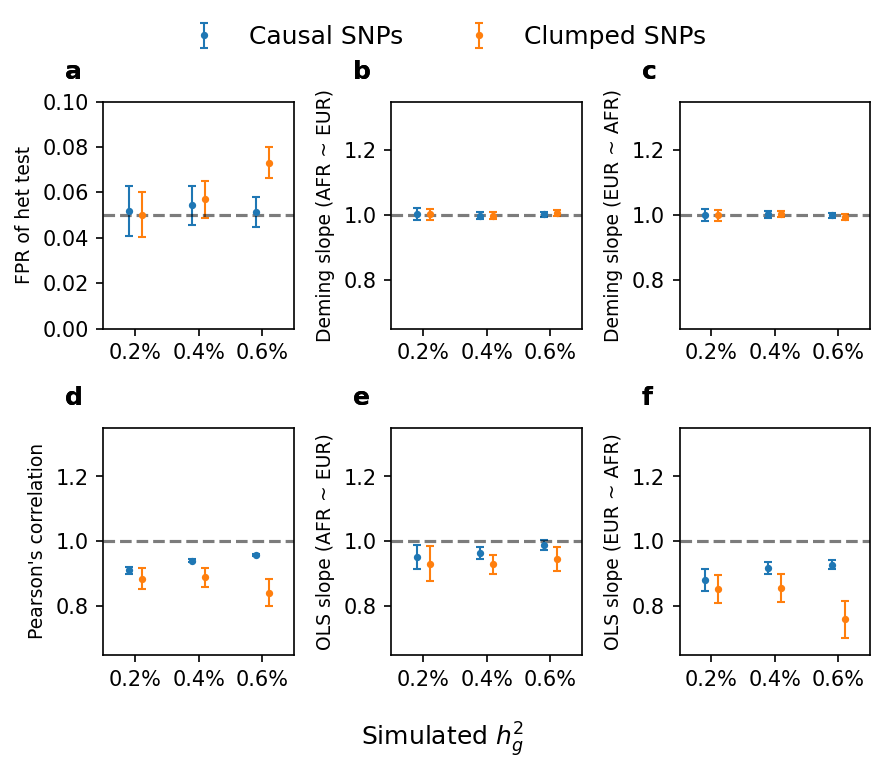

In [8]:
y_var_list = [
    "het_fpr",
    "deming_afr~eur",
    "deming_eur~afr",
    "pearsonr",
    "ols_afr~eur",
    "ols_eur~afr",
]
y_label_list = [
    "FPR of het test",
    "Deming slope (AFR ~ EUR)",
    "Deming slope (EUR ~ AFR)",
    "Pearson's correlation",
    "OLS slope (AFR ~ EUR)",
    "OLS slope (EUR ~ AFR)",
]
dict_ylim = {
    "het_fpr": [0, 0.1],
    "pearsonr": [0.65, 1.35],
    "ols_afr~eur": [0.65, 1.35],
    "ols_eur~afr": [0.65, 1.35],
    "deming_afr~eur": [0.65, 1.35],
    "deming_eur~afr": [0.65, 1.35],
}
dict_hline = {
    "het_fpr": 0.05,
    "pearsonr": 1.0,
    "ols_afr~eur": 1.0,
    "ols_eur~afr": 1.0,
    "deming_afr~eur": 1.0,
    "deming_eur~afr": 1.0,
}

fig, axes = plt.subplots(figsize=(6, 4.5), ncols=len(y_var_list) // 2, nrows=2, dpi=150)
axes = axes.flatten()

# for causal SNPs and clumped SNPs
for group_i, group in enumerate(["causal", "clump"]):
    df_mean, df_sem = dict_df_plot[group]
    # filter for single causal variant
    df_mean = df_mean[df_mean.ncausal == 1].drop(columns=["ncausal"])
    df_sem = df_sem[df_sem.ncausal == 1].drop(columns=["ncausal"])

    # for each panel
    for i, (y_var, y_label) in enumerate(zip(y_var_list, y_label_list)):
        ax = axes[i]
        hsq_list = df_mean.hsq.unique()

        if i == 0:
            label = "Causal SNPs" if group == "causal" else "Clumped SNPs"
        else:
            label = None

        ax.errorbar(
            np.arange(len(hsq_list)) - 0.1 + 0.2 * group_i,
            df_mean[y_var],
            yerr=df_sem[y_var] * 1.96,
            fmt=".",
            ms=5,
            mew=1,
            label=label,
            linewidth=1,
            capsize=2,
        )

        ax.axhline(y=dict_hline[y_var], color="black", ls="--", alpha=0.3)
        ax.set_xticks(np.arange(len(hsq_list)))
        ax.set_xticklabels([f"{hsq * 100}%" for hsq in hsq_list])
        ax.set_xlim(-0.5, len(hsq_list) - 0.5)

        ax.set_ylabel(y_label, fontsize=9)

        ax.set_ylim(dict_ylim[y_var])

        # annotation
        ax.text(
            -0.2,
            1.1,
            string.ascii_lowercase[i],
            transform=ax.transAxes,
            size=12,
            weight="bold",
        )

# trick to put title in the same row
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    ncol=5,
    loc="center",
    bbox_to_anchor=[0.5, 1.0],
    frameon=False,
    fontsize=12,
)

fig.text(
    0.5,
    -0.05,
    "Simulated $h_g^2$",
    fontsize=12,
    ha="center",
)

plt.tight_layout()
fig.savefig("results/locus-simulation-single-causal.pdf", bbox_inches="tight")

plt.show()

# Multiple causal variants figure

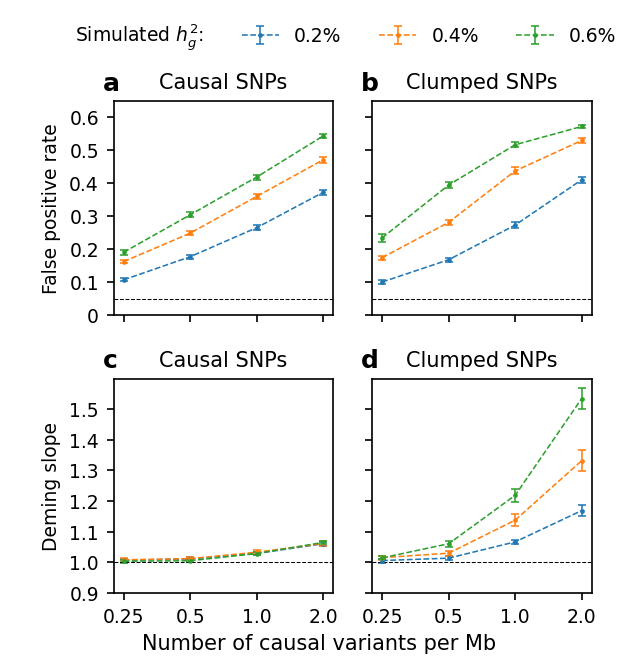

In [9]:
yvar_list = [
    "het_fpr",
    "deming_afr~eur",
]
dict_ylabel = {
    "het_fpr": "False positive rate",
    "deming_afr~eur": "Deming slope",
}
dict_ylim = {
    "het_fpr": [0, 0.65],
    "deming_afr~eur": [0.9, 1.6],
}
dict_yticks = {
    "het_fpr": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    "deming_afr~eur": [0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5],
}
fig, axes = plt.subplots(
    figsize=(4, 4), nrows=2, ncols=2, dpi=150, sharex=True, sharey="row"
)
for group_i, group in enumerate(["causal", "clump"]):
    df_mean, df_sem = dict_df_plot[group]
    # filter for multiple causal
    df_mean = df_mean[df_mean.ncausal > 3]
    df_sem = df_sem[df_sem.ncausal > 3]

    for yvar_i, yvar in enumerate(yvar_list):
        ax = axes[yvar_i, group_i]
        for hsq_i, hsq in enumerate(df_plot.hsq.unique()):
            df_mean_tmp = df_mean[df_mean.hsq == hsq]
            df_sem_tmp = df_sem[df_sem.hsq == hsq]
            ax.errorbar(
                np.arange(len(df_mean_tmp.ncausal)),
                df_mean_tmp[yvar],
                yerr=df_sem_tmp[yvar] * 1.96,
                fmt=".--",
                label=f"{hsq * 100}%",
                ms=3,
                linewidth=0.75,
                mew=0.75,
                capsize=2,
            )

        ax.axhline(y=dict_hline[yvar], color="black", ls="--", alpha=1.0, lw=0.5)
        ax.set_xticks(np.arange(len(df_mean_tmp.ncausal)))

        #         ax.set_xticklabels(df_mean_tmp.ncausal, fontsize=9)
        ax.set_xticklabels([str(i) for i in (df_mean_tmp.ncausal - 1) / 20], fontsize=9)
        ax.set_yticks(dict_yticks[yvar])
        ax.set_yticklabels(dict_yticks[yvar], fontsize=9)
        if group_i == 0:
            ax.set_ylabel(dict_ylabel[yvar], fontsize=9)
            ax.set_ylim(dict_ylim[yvar])

        if group == "causal":
            ax.set_title("Causal SNPs", fontsize=10)
        elif group == "clump":
            ax.set_title("Clumped SNPs", fontsize=10)

        # annotation
        ax.text(
            -0.05,
            1.05,
            string.ascii_lowercase[yvar_i * 2 + group_i],
            transform=ax.transAxes,
            size=12,
            weight="bold",
        )

# trick to put title in the same row
handles, labels = axes[0, 0].get_legend_handles_labels()
ph = [plt.plot([], marker="", ls="")[0]]  # Canvas
handles = ph + handles
labels = ["Simulated $h_g^2$:"] + labels  # Merging labels
fig.legend(
    handles,
    labels,
    ncol=6,
    loc="center",
    bbox_to_anchor=[0.5, 1.02],
    frameon=False,
    fontsize=9,
)

fig.text(
    0.5,
    -0.0,
    "Number of causal variants per Mb",
    fontsize=10,
    ha="center",
)


plt.tight_layout()
fig.savefig("results/locus-simulation-multiple-causal.pdf", bbox_inches="tight")
plt.show()